# Kalman Filtering and Recurrent Neural Networks for Fuel Moisture
## Jan Mandel, University of Colorado Denver


## Abstract

''Fuel moisture is an important factor of the spread of wildland fires. Some weather stations have fuel moisture sensors and data are available online. We review a simple model of fuel moisture from atmospheric conditions, and show how to adjust the model using the weather station data.

## Table of contents

1 Introduction

2 Background

2.1 Imports

2.2 Kalman filter

2.2.1 Overview

2.2.2 Formulation

2.2.3 A Kalman filter tester

2.3 Fuel moisture model

2.3.1 A simple time lag model

2.3.1 Fuel moisture model with drying equilibrium, wetting equilibrium, and rain

3 Methods

3.1 Kalman filter demonstration on the simple model

3.1.1 Creating synthetic data

3.1.2 Running the Kalman filter

3.2 Acquisition and preprocessing of real data

3.2.1 Acquisition of fuel moisture observations

3.2.2 Acquisition of weather data

3.2.3 Preprocessing and visualization of the weather data

4 Results

4.1 Kalman filter with fuel moisture observations, followed by forecasting

4.2 Model with an augmented state

4.3 Kalman filter on the augmented model

4.4 A comment on the information flow in the Kalman filter and in neural networks

5. Conclusion

Contributions of Authors

Acknowledgements

References









## 1 Introduction

The Kalman filter is at the foundation of many technologies in daily use, from GPS to weather forecasting. No model is completely accurate. Think space navigation: the movement of a Apollo 13 between the moon and the earth, subject to gravitational forces and propulsion, with the position ascertained by visual measurements. No matter how accurate the model of spacecraft motion is, the measurements are always burdened with noise. The idea of Kalman filter is to evolve a quantification of the of the state (here, positin and velocity of the spacecraft) in the form of a covariance matrix, and, using an estimate of the uncertainty of the data, adjust the state to split the difference every time measurements are taken. 

Here, we use the Kalman filter to estimate the evolution of fuel (dead wood) moisture content from a simple theoretical model, adjusting the state of the model hourly for measurements from fuel moisture a sensor in a wood stick exposed to the elements. This is needed for forecasting of wildfire progress; for this purpose, we also want to have the filter adjust the model from the data, so that it gives more accurate data for future when we only have hourly weather forecast but no actual data - because the future has not happened yet. 

## 2 Background

In this section, we take care of preliminaries: we install some packages we need, and then proceed with the Kalman filter.

### 2.1 Imports

We may need the pygrib package to read weather data, but pygrib requires current numpy while google colab is using an old numpy version for compatibility with tensorflow. We will upgrade numpy and restart the runtime then the notebook will need to be run again. If numpy is current, we just download and import packages we need.

### 2.2 Kalman filter

#### 2.2.1 Overview

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

See Kalman (1960) for the original publication, Kalnay (2003) for a gentle introduction, and the [Wikipedia article](https://en.wikipedia.org/wiki/Extended_Kalman_filter).

#### 2.2.2 Formulation

---



We present the Kalman filter in perhaps the most used form, as extended to nonlinear models.
 Consider a discrete time model of some natural
process. At time step $k$, the model has state $u_{k}\in\mathbb{R}^{n}$, which
can be approximated from the previous step $u_{k-1}$ by applying the model
$\mathcal{M}$ to get a forecast $u_{k}^{f}=\mathcal{M}\left(  u_{k-1}\right)
$. We model uncertainty in the model itself by adding normally distributed
noise with mean zero and covariance $Q$ to the uncertainty of $u_{k}^{f}$. We
also need to estimate now the uncertainty in the previous state $u_{k-1}$
propagates to the uncertainty of the forecast $u_{k}^{f}$. So, assume that the
model is differentiable and quantify the uncertainty of the state by a
covariance matrix. That is,  assume that at step $k-1$, the state has
(approximately) normal distribution with mean $u_{k-1}$ and covariance
$P_{k-1}$. Using the Taylor expansion of order $1$ of the model operator at
$u_{k-1}$, $\mathcal{M}\left(  u\right)  \approx\mathcal{M}\left(
u_{k-1}\right)  +\mathcal{M}^{\prime}\left(  u_{k-1}\right)  \left(
u-u_{k-1}\right)  $, where $\mathcal{M}^{\prime}\left(  u_{k-1}\right)  $ is
the Jacobian matrix of $\mathcal{M}$ at $u_{k-1}$. It can be shown that the
forecast has then (approximately)\ normal distribution with mean and
covariance
$$
u_{k}^{f}=\mathcal{M}\left(  u_{k-1}\right)  ,\ P_{k}^{f}=\mathcal{M}\left(
u_{k-1}\right)  P_{k-1}\mathcal{M}^{\prime}\left(  u_{k-1}\right)  +Q
$$
At time $k$, we also have an observation $d_{k}\approx Hu_{k}$, where $H$ is a
given observation operator, and we want to find $u_{k}$ so that both
$$
u_{k}\approx u_{k}^{f}\text{ and }d_{k}\approx Hu_{k}.
$$
We quantify the uncertainly of the error of observation $d_{k}$ by a covariance
matrix $R$: assume that the observation error has normal probability
distribution with a known covariance $R$. Then, the likelihood of state $u$ is
proportional to $e^{-\left\Vert d_{k}-Hu\right\Vert _{R^{-1}}^{2}/2}$, where
we used the notation for the norm $\left\Vert v\right\Vert _{A}%
=\left(v^{\top}Av\right)^{1/2}$ induced by a positive definite matrix $A$. Similarly, we quantify the
uncertainty of the state by a covariance matrix $P_{k}$. That is, the forecast
state has (approximately) normal distribution with mean $u_{k}^{f}$  and covariance
$P_{k}^{f}$. From the Bayes theorem of statistics, the probability distribution
of the state after taking the data into account has density
$$
p_{k}\left(  u\right) \propto e^\frac{-\left\Vert d_{k}
-Hu\right\Vert_{R^{-1}}^{2}}{2}e^\frac{-\left\Vert u-u_{k}^{f}\right\Vert _{
{P_{k}^f}^{-1}  }^{2}}{2}%
$$
where $\propto$ means proportional.
Note that the probability density at $u$ is maximal when $\left\Vert
d_{k}-Hu\right\Vert _{R^{-1}}^{2}+\left\Vert u-u_{k}\right\Vert _{{P_{k}^{f}}^{-1}}^{2}$
 is minimal, which quantifies the statement that $d_{k}\approx
Hu_{k}$ and $u\approx u_{k}^{f}$.  By a direct computation completing the
square and using the Sherman-Morrison-Woodbury formula, 
$$p_{k}\left(
		u
	   \right) \propto 
e^{-\frac{
	\left\Vert u-u_{k
	         }
	\right\Vert_
		{P_{k
		      }^{-1}
		}^{2}
	}
	{2}},
$$ 
which is the density of the normal distribution with the mean
$$
u_{k}^{f}=u_{k}^{f}+K_{k}(d-Hu_{k}^{f}),\ \text{where }K_{k}=P_{k}%
^{f}H^{\mathrm{T}}(HP_{k}^{f}H^{\mathrm{T}}+R)^{-1}%
$$
and covariance
$$
P_{k}=\left(  \left(  P_{k}^{f}\right)  ^{-1}+H^{\mathrm{T}}R^{-1}H\right)
^{-1}=(I-KH)P_{k}^{f}.
$$

These are the equations of the extended Kalman filter. The original Kalman (1960) filter was
formulated for a linear process. The extension to the
nonlinear case made broad array of applications possible, including the Apollo spacecraft naviation (McGee and Schmidt, 1966),  and is
still a de-facto standard in navigation and GPS.


In [ ]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param F:   the model function, args vector u, returns F(u) and Jacobian J(u)
  :param Q:   the process model noise covariance, shape (n,n)
  :param d:   data vector, shape (m). If none, only advance in time
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  J = d2(J)              # if scalar, make jacobian a 2D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


#### 2.2.3 A Kalman filter tester

It is a very good idea to make write a simple tester for every piece of code. How else would we know it actually works, and that something basic did not get broken inadvertently, perhaps as a side effect of changing something else? A simple tester may save a great deal of time trying to debug cryptic errors later. And, what better place for a tester that right after the code it is testing so that it gets run every time?

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)


### 2.3  Fuel moisture models




#### 2.3.1 A simple fuel moisture model

First consider a simplified fuel moisture model without considering the effect of rain.
The evolution of fuel moisture content $m(t)$ is modeled by the time-lag differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [ ]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):  
  # Arguments: 
  #   m0          fuel moisture content at start dimensionless, unit (1)
  #   E           fuel moisture eqilibrium (1)
  #   partials=0: return m1 = fuel moisture contents after time tlen (1)
  #           =1: return m1, dm0/dm0 
  #           =2: return m1, dm1/dm0, dm1/dE
  #           =3: return m1, dm1/dm0, dm1/dE dm1/dT1   
  #   T1          1/T, where T is the time constant approaching the equilibrium
  #               default 0.1/hour
  #   tlen        the time interval length, default 1 hour

  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, dm1_dm0          # return value and Jacobian
  dm1_dE = 1 - exp_t      
  if partials==2:
     return m1, dm1_dm0, dm1_dE 
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  if partials==3:
    return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  raise('Bad arg partials')
  

#### 2.3.2 Fuel moisture model with drying equilibrium, wetting equilibrium, and rain

Here is a little more realistic fuel moisture model from Mandel et al. (2004). A rain-wetting lag time $t_{\mathrm{r}}$ is reached for heavy rain only
asymptotically, when the rain intensity $r$ (mm/h) is
large:
$$
\frac{\mathrm{d}m}{\mathrm{d}t}=\frac{S-m}{t_{\mathrm{r}}}\left(1-\exp\left(-\frac{r-r_0}{r_{\mathrm{s}}}
\right)  \right),\ \text{if}\ r>r_0, 
$$
where $r_0$ is the threshold rain intensity below which no perceptible
wetting occurs, and $r_{\mathrm{s}}$ is the saturation rain
intensity. At the saturation rain intensity, $1-1/e\approx 0.63$ of
the maximal rain-wetting rate is achieved. For 10h fuel, the model takes $S=250\,{\%}$,
$t_{\mathrm{r}}=14$h, $r_0=0.05$mm/h and
$r_{\mathrm{s}}=8$mm/h. 

In [ ]:
### Define model function with drying, wetting, and rain equilibria

# Parameters
r0 = 0.05                                   # threshold rainfall [mm/h]
rs = 8.0                                    # saturation rain intensity [mm/h]
Tr = 14.0                                   # time constant for rain wetting model [h]
S = 250                                     # saturation intensity [dimensionless]
T = 10.0                                    # time constant for wetting/drying

def model_moisture(m0,Eqd,Eqw,r,t,partials=0,T=10.0,tlen=1.0):
    # arguments:
    # m0         starting fuel moistureb (%s
    # Eqd        drying equilibrium      (%) 
    # Eqw        wetting equilibrium     (%)
    # r          rain intensity          (mm/h)
    # t          time
    # partials = 0, 1, 2
    # returns: same as model_decay
    #   if partials==0: m1 = fuel moisture contents after time 1 hour
    #              ==1: m1, dm1/dm0 
    #              ==2: m1, dm1/dm0, dm1/dE  
    
    if r > r0:
        # print('raining')
        E = S
        T1 =  (1.0 - np.exp(- (r - r0) / rs)) / Tr
    elif m0 <= Eqw: 
        # print('wetting')
        E=Eqw
        T1 = 1.0/T
    elif m0 >= Eqd:
        # print('drying')
        E=Eqd
        T1 = 1.0/T
    else: # no change'
        E = m0
        T1=0.0
    exp_t = np.exp(-tlen*T1)
    m1 = E + (m0 - E)*exp_t  
    dm1_dm0 = exp_t
    dm1_dE = 1 - exp_t
    #if t>=933 and t < 940:
    #  print('t,Eqw,Eqd,r,T1,E,m0,m1,dm1_dm0,dm1_dE',
    #        t,Eqw,Eqd,r,T1,E,m0,m1,dm1_dm0,dm1_dE)   
    if partials==0: 
        return m1
    if partials==1:
        return m1, dm1_dm0
    if partials==2:
        return m1, dm1_dm0, dm1_dE
    raise('bad partials')

## 3. Methods

### 3.1 Kalman filter demonstration on the simple model

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as the values of the "truth", with random noise to simulate observation error.

#### 3.1.1 Creating synthetic data

In [ ]:
def create_synthetic_data(days=20,power=4,data_noise=0.02,process_noise=0.0,DeltaE=0.0):
  import numpy as np, random
  hours = days*24
  h2 = int(hours/2)
  hour = np.array(range(hours))
  day = np.array(range(hours))/24.

  # artificial equilibrium data
  E = np.power(np.sin(np.pi*day),4) # diurnal curve
  E = 0.05+0.25*E
  # FMC free run
  m_f = np.zeros(hours)
  m_f[0] = 0.1         # initial FMC
  process_noise=0.
  for t in range(hours-1):
    m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,process_noise) )
  data = m_f + np.random.normal(loc=0,scale=data_noise,size=hours)
  E = E + DeltaE    

  %matplotlib inline
  import matplotlib.pyplot as plt 
  # fig1, ax1 = plt.subplots()

  plt.figure(figsize=(16,4))
  plt.plot(hour,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(hour,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(hour[:h2],data[:h2],c='b',label='10-h fuel data')
  plt.title('Synthetic data')
  plt.xlabel('Time (hours)')
  plt.ylabel('Fuel moisture content (%)')
  plt.legend()
  return E,m_f,data,hour,h2


In [ ]:
E,m_f,data,hour,h2 = create_synthetic_data(days=20,power=4,data_noise=0.000,process_noise=0.0,DeltaE=0.0) 

#### 3.1.2 Running the Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

# using global E, m_f

def plot_m(m,Ec=None,title=None,):  # global hour
  hours=hour.shape[0]
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(hour,E,linestyle='--',c='r',label='E=Equilibrium data')
  # print(len(hour),len(m_f))
  plt.plot(hour,m_f,linestyle='-',c='b',label='m_f=10-h fuel truth')
  plt.scatter(hour[:h2],data[:h2],c='b',label='data=10-h fuel data')
  if m is not None:
    plt.plot(hour[:h2],m[:h2],linestyle='-',c='k',label='m=filtered')
    plt.plot(hour[h2:hours],m[h2:hours],linestyle='-',c='r',label='m=forecast')
  if Ec is not None:
    plt.plot(hour,Ec,linestyle='-',c='g',label='Ec=Equilibrium correction')
  if title is not None:
    plt.title(title) 
  else:
    plt.title('Kalman filtering and forecast on artificial data')
  plt.xlabel('Time (hours)') 
  plt.ylabel('Fuel moisture content (%)')
  plt.legend()

def kf_example(DeltaE):
  hours=hour.shape[0]
  m = np.zeros(hours)
  m[0]=0.1             # background state  
  P = np.zeros(hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(h2):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(h2,hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  return m, P
 

In [ ]:
DeltaE = 0.0          # bias
m, P = kf_example(DeltaE)
plot_m(m)


We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Let's have a look at the evolution of the filter's estimate of the variance $P$. A common problem with the Kalman filter is when the variance converges to zero over time, then, since the filter trusts the model too much, it ignores the observations. Of course, once we switch to forecasting mode, the variance is not of interest. We could keep evolving the variance to bridge over periods when there are no observations, but not in this simplified version.

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(P,linestyle='-',c='b',label='Estimated state variance P')
plt.title('Kalman filtering and forecast on artificial data')
plt.xlabel('Time (hours)') 
plt.ylabel('Estimated variance of fuel moisture (%^2)')
plt.legend()

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

In [ ]:
DeltaE = -0.05
m, P = kf_example(DeltaE)
plot_m(m)

In [ ]:
DeltaE = 0.05
m, P = kf_example(DeltaE)
plot_m(m)

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree - as soon as there is no data to attract the simulation, the model is doing its own thing.

#### 3.2 Model with an augmented state

In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.


Define augmented model function. Also, add use drying, wetting, and rain equilibria

In [ ]:
def model_augmented(u0,Ed,Ew,r,t):
    # state u is the vector [m,dE] with dE correction to equilibria Ed and Ew at t
    # 
    m0, Ec = u0  # decompose state u0
    # reuse model_moisture(m0,Eqd,Eqw,r,partials=0):
    # arguments:
    # m0         starting fuel moistureb (1)
    # Ed         drying equilibrium      (1) 
    # Ew         wetting equilibrium     (1)
    # r          rain intensity          (mm/h)
    # partials = 0, 1, 2
    # returns: same as model_decay
    #   if partials==0: m1 = fuel moisture contents after time 1 hour
    #              ==1: m1, dm0/dm0 
    #              ==2: m1, dm1/dm0, dm1/dE 
    m1, dm1_dm0, dm1_dE  = model_moisture(m0,Ed + Ec, Ew + Ec, r, t, partials=2)
    u1 = np.array([m1,Ec])   # dE is just copied
    J =  np.array([[dm1_dm0, dm1_dE],
                   [0.     ,     1.]])
    return u1, J

In [ ]:
def run_augmented_kf(d,Ed,Ew,rain,h2,hours):
  u = np.zeros((2,hours))
  u[:,0]=[0.1,0.0]       # initialize,background state  
  P = np.zeros((2,2,hours))
  P[:,:,0] = np.array([[1e-3, 0.],
                      [0.,  1e-3]]) # background state covariance
  Q = np.array([[1e-3, 0.],
                [0,  1e-3]]) # process noise covariance
  H = np.array([[1., 0.]])  # first component observed
  R = np.array([1e-3]) # data variance

  # ext_kf(u,P,F,Q=0,d=None,H=None,R=None) returns ua, Pa

  # print('initial u=',u,'P=',P)
  # print('Q=',Q,'H=',H,'R=',R)

  for t in range(1,h2):
      # use lambda construction to pass additional arguments to the model 
      u[:,t],P[:,:,t] = ext_kf(u[:,t-1],P[:,:,t-1],
                                  lambda uu: model_augmented(uu,Ed[t],Ew[t],rain[t],t),
                                  Q,d[t],H=H,R=R)
      # print('time',t,'data',d[t],'filtered',u[0,t],'Ec',u[1,t])
  for t in range(h2,hours):
      u[:,t],P[:,:,t] = ext_kf(u[:,t-1],P[:,:,t-1],
                                  lambda uu: model_augmented(uu,Ed[t],Ew[t],rain[t],t),
                                  Q*0.0)
      # print('time',t,'data',d[t],'forecast',u[0,t],'Ec',u[1,t])
  return u

In [ ]:
def augmented_example(DeltaE):
  hours=hour.shape[0]
  h2 = int(hours/2)
  m, Ec = run_augmented_kf(data,E+DeltaE,E+DeltaE,0*E,h2,hours)  # data, E, hours are global
  return m, Ec

In [ ]:
m, Ec=augmented_example(0.1)
plot_m(m, Ec)

In [ ]:
m, Ec=augmented_example(0.0)
plot_m(m, Ec)

In [ ]:
m, Ec=augmented_example(-0.1)
plot_m(m, Ec)

## From Kalman filter to neural networks

In the Kalman filter, at each time step $k$,

* the input state is $u_{k-1}$ size $n$ and its covariance matrix $P_{k-1}$ size $n \times n$.
* the model is applied to external data $e_k$ and the input $u_{k-1},P_{k-1}$ produce the forecast $u_k^f$ and its covariance $P^f_k$
* the new state $u_k$ is found by minimizing $|| u^f_k - u_k||^2_{P^f_k} + ||H u_k - d_k||^2_{R}$   
* the new state covariance is $P_k = ( (P^f_k)^{-1} + H^\top R^{-1} H)^{-1}$.

Here, the state consists of 
* the fuel moisture and the adjustment to the equilibrium, dimension 2
* the covariance matrix of vector of dimension 2, which is symmetric $2 \times 2$ matrix, given by 3 numbers because it is symmetric
Thus, the dimension of the state is 2 + 3 = 5. The first component of the state, the fuel moisture, is the quantity of interest, the rest are auxiliary.


This can be understood as:

* a mapping $M$ of the 5-dimensional hidden and external data state to a new hidden state:
$$M:(u_{k-1},P_{k-1},e_k) \mapsto (u_{k},P_{k})$$
* retrieving the output (the quantity of interest) as the first component of the hiddent state
* feeding the hiddent state back to the mapping $M$ for the next step $k+1$
* training consists of fitting the hidden state to minimize a loss function
$$\ell(u_{k},P_{k},d_k,R_k) \to \min$$

Note that in the augmented Kalman filter above, the mapping $M$ is fixed and it has a one component of the hidden state as a parameter. To get a better fit, we could increase the number of parameters, e.g., by modeling the moisture in multiple layers, as in van der Kamp et al. (2017) two-layer model.


Building and evaluating RNN

A recurrent neural network (RNN) has a similar information flow but it can be more flexible and look for the best model automatically, i.e., build the model from data. 

We'll start by how to evaluate the map, then actually create it later.

Some of the code is from https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/


In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    inputs = tf.keras.Input(shape=input_shape)
    # https://stackoverflow.com/questions/43448029/how-can-i-print-the-values-of-keras-tensors
    # inputs2 = K.print_tensor(inputs, message='inputs = ')  # change allso inputs to inputs2 below, must be used
    x = tf.keras.layers.SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation[0])(inputs)
    outputs = tf.keras.layers.Dense(dense_units, activation=activation[1])(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Demo example
hidden=5
features=2
timesteps=3
demo_model = create_RNN(hidden_units=hidden, dense_units=1, 
                        input_shape=(timesteps,features), 
                        activation=['linear', 'linear'])
print(demo_model.summary())
w = demo_model.get_weights()
#print(len(w),' weight arrays:',w)
wname=('wx','wh','bh','wy','by','wz','bz')
for i in range(len(w)):
  print(i,':',wname[i],'shape=',w[i].shape)
wx, wh, bh, wy, by = w
plot_model(demo_model, to_file='model_plot.png', 
  show_shapes=True, show_layer_names=True,
  expand_nested=True,)

The input layer here is just a formality. The input of the hidden layer `simple_rnn` consist of vector passed by the input layer, followed by its own output from the previous time step.

Now let’s do a simple experiment to see how the layers from a SimpleRNN and Dense layer produce an output. Keep this figure in view.
<img src="https://machinelearningmastery.com/wp-content/uploads/2021/09/rnnCode1.png">

We’ll input x for three time steps and let the network generate an output. The values of the hidden units at time steps 1, 2 and 3 will be computed. $h(0)$ is initialized to the zero vector. The output $o(3)$ is computed from $h(3)$ and $w(3)$. An activation function is linear, $f(x)=x$, so the update of  $h(k)$  and the output $o(k)$ are given by
\begin{align*}
h\left(  0\right)  = &0  \\
h\left(  k+1\right)  =& 
x\left(  k\right) w_{x}
  +h(k) w_{h}  + b_{h}\\
o(k+1)=& h(k+1)w_{y} + b_y
\end{align*}

In [ ]:
# Reshape the input to sample_size x time_steps x features 
samples=4   # number of samples
x = tf.reshape(tf.range(samples*timesteps*features),[samples,timesteps,features]) 
print('test input x=',x)
print('model.predict start')
y_pred_model = demo_model.predict(x)
print('model.predict end')

o3=np.zeros([samples,1])
for i in range(samples):
  h_0 = np.zeros(hidden)
  h_1 = np.dot(x[i,0,:], wx) + np.dot(h_0,wh) + bh
  h_2 = np.dot(x[i,1,:], wx) + np.dot(h_1,wh) + bh
  h_3 = np.dot(x[i,2,:], wx) + np.dot(h_2,wh) + bh
  o3[i,0] = np.dot(h_3, wy) + by
#print('h1 = ', h_1,'h2 = ', h_2,'h3 = ', h_3)

print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

The result is the same.

#### Training and forecasting with the RNN

We are given a sequence `x` of inputs size `[train_steps+forecast_steps,features]` and want to train a model so that at step `i` in `range(train_steps)`, the model returns close to `features[i,:]`. The trained model then returns for `i` in `range(train_steps,train_steps+forecast_steps)` a forecast `features[i,:]`.

In [ ]:
def staircase(x,y,timesteps,trainsteps):
  # x [trainsteps+forecaststeps,features]    all inputs
  # y [trainsteps,outputs]
  # timesteps: split x and y into samples length timesteps, shifted by 1
  # trainsteps: number of timesteps to use for training, no more than y.shape[0]
  print('shape x = ',x.shape)
  print('shape y = ',y.shape)
  print('timesteps=',timesteps)
  print('trainsteps=',trainsteps)
  outputs = y.shape[1]
  features = x.shape[1]
  forecaststeps = x.shape[0]-trainsteps
  samples = trainsteps-timesteps+1
  print('staircase: samples=',samples,'timesteps=',timesteps,'features=',features)
  x_train = np.empty([samples, timesteps, features])
  y_train = np.empty([samples, outputs])  # only the last
  for i in range(samples):
    for j in range(features):
      for k in range(timesteps):
        x_train[i,k,j] = x[i+k,j]
    for j in range(outputs):
      y_train[i,j] = y[i+timesteps-1,j]
  return x_train, y_train

In [ ]:
def seq2batches(x,y,timesteps,trainsteps):
  # x [trainsteps+forecaststeps,features]    all inputs
  # y [trainsteps,outputs]
  # timesteps: split x and y into samples length timesteps, shifted by 1
  # trainsteps: number of timesteps to use for training, no more than y.shape[0]
  print('shape x = ',x.shape)
  print('shape y = ',y.shape)
  print('timesteps=',timesteps)
  print('trainsteps=',trainsteps)
  outputs = y.shape[1]
  features = x.shape[1]
  samples= trainsteps - timesteps + 1
  print('samples=',samples)
  x_train = np.empty([samples, timesteps, features])
  y_train = np.empty([samples, timesteps, outputs])  # only the last
  print('samples=',samples,' timesteps=',timesteps,
        ' features=',features,' outputs=',outputs)
  for i in range(samples):
    for k in range(timesteps):
      for j in range(features):
        x_train[i,k,j] = x[i+k,j]
      for j in range(outputs):
        y_train[i,k,j] = y[i+k,j]  # return sequences
  return x_train, y_train

In [ ]:
print('test preprocessing for RNN')
trainsteps=5
features=1
outputs=1
timesteps=3
x = tf.reshape(tf.range(trainsteps*features),[trainsteps,features])
y = tf.reshape(tf.range(trainsteps*outputs),[trainsteps,outputs])
print('x=',x)
print('y=',y)
x_train, y_train = staircase(x,y,timesteps,trainsteps)
print('x_train=',x_train)
print('y_train=',y_train)
x_train, y_train = seq2batches(x,y,timesteps,trainsteps)
print('x_train=',x_train)
print('y_train=',y_train)

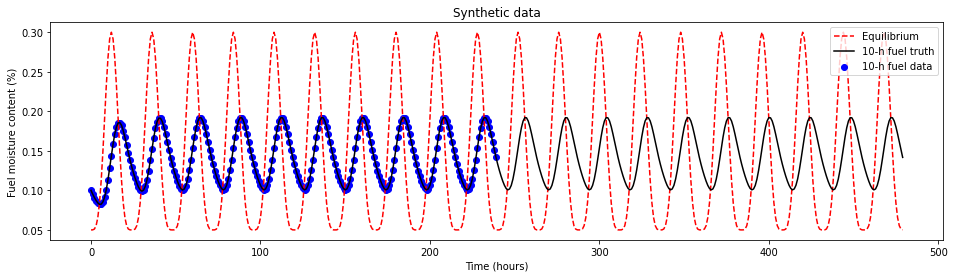

In [110]:
E,m_f,data,hour,h2 = create_synthetic_data(days=20,power=4,data_noise=0.0,process_noise=0.0,DeltaE=0.0) 

In [112]:
scale=False
# transform as 2D, (timesteps, features) and (timesteps, outputs)
Et = np.reshape(E,[E.shape[0],1])
datat = np.reshape(data,[data.shape[0],1])
if scale:
  scalerx = MinMaxScaler()
  scalerx.fit(Et)
  Et = scalerx.transform(Et)
  scalery = MinMaxScaler()
  scalery.fit(datat)
  datat = scalery.transform(datat)
x_train, y_train = staircase(Et,datat,timesteps=1,trainsteps=h2)
print('x_train shape=',x_train.shape)
samples, timesteps, features = x_train.shape
print('y_train shape=',y_train.shape)

shape x =  (480, 1)
shape y =  (480, 1)
timesteps= 1
trainsteps= 240
staircase: samples= 240 timesteps= 1 features= 1
x_train shape= (240, 1, 1)
y_train shape= (240, 1)


In [113]:
def create_RNN_2(hidden_units, dense_units, activation, stateful=False, 
                 batch_shape=None, input_shape=None, dense_layers=1):
    if stateful:
      inputs = tf.keras.Input(batch_shape=batch_shape)
    else:
      inputs = tf.keras.Input(shape=input_shape)
    # https://stackoverflow.com/questions/43448029/how-can-i-print-the-values-of-keras-tensors
    # inputs2 = K.print_tensor(inputs, message='inputs = ')  # change allso inputs to inputs2 below, must be used
    x = inputs
    x = tf.keras.layers.SimpleRNN(hidden_units,activation=activation[0],stateful=stateful)(x)
    # x = tf.keras.layers.Dense(hidden_units, activation=activation[1])(x)
    for i in range(dense_layers):
      x = tf.keras.layers.Dense(dense_units, activation=activation[1])(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
def create_fit_predict_RNN(hidden_units, dense_units, 
                             samples, timesteps, features, dense_layers=1, activation=['tanh', 'tanh']):
    # statefull model version with with fixed number of batches
    model_fit=create_RNN_2(hidden_units=hidden_units, dense_units=dense_units, 
                        batch_shape=(samples, timesteps, features),stateful = True,
                        activation=activation,dense_layers=dense_layers)
    print(model_fit.summary())
    # same model for prediction on the entire dataset
    model_predict=create_RNN_2(hidden_units=hidden_units, dense_units=dense_units,  
                        input_shape=(None,features),stateful = False,
                        activation=activation,dense_layers=dense_layers)
    print(model_predict.summary())
    return model_fit, model_predict

In [114]:
# the simplest model possible
fmda_model, fmda_model_eval = create_fit_predict_RNN(hidden_units=1, dense_units=1, 
      samples=samples, timesteps=timesteps, features=1, dense_layers=0,
      activation=['linear'])
# fmda_model.fit(x_train, y_train, epochs=40, verbose=2,batch_size=samples)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(240, 1, 1)]             0         
                                                                 
 simple_rnn_33 (SimpleRNN)   (240, 1)                  3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, None, 1)]         0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-t

[array([[0.1]]), array([[0.9]]), array([0.])]
mt= [[0.005     ]
 [0.00500726]
 [0.00511218]
 [0.00553617]
 [0.0065625 ]
 [0.00843343]
 [0.01125   ]
 [0.01490391]
 [0.0190625 ]
 [0.02321384]
 [0.02676282]
 [0.0291554 ]
 [0.03      ]
 [0.0291554 ]
 [0.02676282]
 [0.02321384]
 [0.0190625 ]
 [0.01490391]
 [0.01125   ]
 [0.00843343]
 [0.0065625 ]
 [0.00553617]
 [0.00511218]
 [0.00500726]
 [0.005     ]
 [0.00500726]
 [0.00511218]
 [0.00553617]
 [0.0065625 ]
 [0.00843343]
 [0.01125   ]
 [0.01490391]
 [0.0190625 ]
 [0.02321384]
 [0.02676282]
 [0.0291554 ]
 [0.03      ]
 [0.0291554 ]
 [0.02676282]
 [0.02321384]
 [0.0190625 ]
 [0.01490391]
 [0.01125   ]
 [0.00843343]
 [0.0065625 ]
 [0.00553617]
 [0.00511218]
 [0.00500726]
 [0.005     ]
 [0.00500726]
 [0.00511218]
 [0.00553617]
 [0.0065625 ]
 [0.00843343]
 [0.01125   ]
 [0.01490391]
 [0.0190625 ]
 [0.02321384]
 [0.02676282]
 [0.0291554 ]
 [0.03      ]
 [0.0291554 ]
 [0.02676282]
 [0.02321384]
 [0.0190625 ]
 [0.01490391]
 [0.01125   ]
 [0.00843343

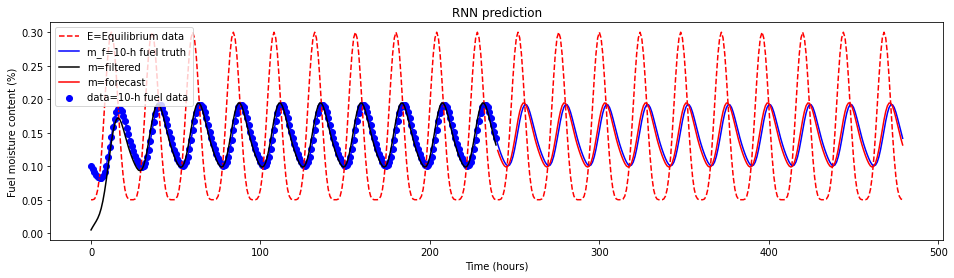

In [119]:
# Same model as stateless for prediction:
w=fmda_model.get_weights()
w=fmda_model_eval.get_weights()
w=[np.array([[0.1]]), np.array([[0.9]]), np.array([0.])]
print(w)
fmda_model_eval.set_weights(w)
# prediction on the entire dataset from zero state
mt = fmda_model_eval.predict(Et)
print('mt=',mt)
h=0
out = np.empty(Et.shape[0])
for i in range(Et.shape[0]):
  h = np.dot(Et[i,0],w[0])+np.dot(h,w[1]) + w[2]
  out[i]=h
print('out=',out)
if scale:
  mt = scalery.inverse_transform(mt)
m = mt[:,0]
plot_m(out,title='RNN prediction')

In [ ]:
fmda_model, fmda_model_eval = create_fit_predict_RNN(hidden_units=7, dense_units=1, 
      samples=samples, timesteps=timesteps, features=1, 
      activation=['tanh', 'tanh'])
fmda_model.fit(x_train, y_train, epochs=40, verbose=2,batch_size=samples)
# Same model as stateless for prediction:
w=fmda_model.get_weights()
fmda_model_eval.set_weights(w)
# prediction on the entire dataset from zero state
mt = fmda_model_eval.predict(Et)
m = scalery.inverse_transform(mt)
plot_m(m,title='RNN prediction')

In [ ]:
x = tf.zeros([3,4])
x.shape[0]
trainsteps,outputs = x.shape
trainsteps,outputs
y = tf.zeros([trainsteps,features])
print(x[1,:])
print(x)


In [ ]:
tf.zeros([1,2,3])

### 3.2 Acquisition and preprocessing of real data

Data assimilation for fuel moisture from Remote Automated Weather Stations (RAWS) was developed in Vejmelka et al. (2016). First, they use regression from all RAWS in a given area to extend the data spatially from RAWS to a grid in the whole area, then they run the extended Kalman filter at each grid node. Here, we are interested in a simplified problem: estimate future fuel moisture at a single RAWS location from weather data.  

#### 3.2.1 Acquisition of fuel moisture observations

We try to load the data from a saved file first. If that fails, retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. Get all stations with fuel moisture data in a spatial box within one hour, then pick one station and retrieve the whole time series.

In [ ]:
import json
jfile = 'raws.json'; vars='fuel_moisture'; case = 1
# jfile = 'raws2.json'; vars='fuel_moisture,precip_accum_one_hour'; case = 2
def json_w(j,f):
  print('writing json file',f)
  json.dump(j,open(f,'w'),indent=4)
try:
    #! wget --no-clobber http://math.ucdenver.edu/~jmandel/data/math4779f21/raws.json
    j = json.load(open(jfile,'r'))
    print('loaded from ',jfile)
    # Take the first station in the boulding box that has data between time_start and time_s2.
    # Then retrieve data for that station between time_start and time_end
    time_start = j['time_start']      # start of data time series
    # time_s2    = j['time_s2']         # end of segment to read coordinates
    time_end  = j['time_end']         # end of data time series
    meso_ts  = j['meso_ts']           # get meso observations time series
    obs_lon =   j['obs_lon']          # where we retrieved observations
    obs_lat =   j['obs_lat']
except:
    print("can't read",jfile,', creating')
    # set up bounds
    time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
    time_s2    = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
    time_end   = "201907200900"  # June 20 2018 09:00 in format yyyymmddHHMM 
    #time_start=  "201810230100"
    #time_s2=  "201810230300"
    #time_end  =  "201806022300"
    !pip install MesoPy
    from MesoPy import Meso
    bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
    meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
    m = Meso(meso_token)# create a Meso object
    print('reading MesoWest fuel moisture data')
    json_w(m.variables(),'variables.json')
    meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, 
                             showemptystations = '0', vars=vars)   # ask the object for data
    json_w(meso_obss,'meso_obss.json')                        
    # pick one station and retrieve the whole time series.
    station=meso_obss['STATION'][0]
    json_w(station,'station.json')
    lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
    print(station['NAME'],'station',station['STID'],'at',lon,lat)
    e = 0.01   # tolerance
    bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
    print('bounding box',bb)
    meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars=vars)   # ask the object for data
    json_w(meso_ts,'meso_ts.json')                        
    obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later
    j={'time_start':time_start,'time_s2':time_s2,'time_end':time_end,
       'meso_ts':meso_ts,'obs_lon':obs_lon,'obs_lat':obs_lat}
    json_w(j,jfile)
    print('done')

In [ ]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import pytz
station = meso_ts['STATION'][0]
time_str  = station['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(station['OBSERVATIONS']["fuel_moisture_set_1"])
# obs_data = np.array(station['OBSERVATIONS']["fuel_moisture"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')
plt.xlabel('Time (hours)') 
plt.ylabel('Fuel moisture content (%)')
plt.legend()
 

In [ ]:
# %debug

#### 3.2.2 Acquisition of weather data

Our weather data are results from atmospheric models, with assimilated observations from weather stations, satellites, radars, etc. The models can be run in reanalysis mode (for the past, with data for the period modeled)  or in forecast mode (for the future, with only past data assimilated - because future data are not here yet). We use the Real-Time Mesoscale Analysis ([RTMA](https://www.nco.ncep.noaa.gov/pmb/products/rtma/)) interpolated to the RAWS location. RTMA is a real-time product, posted hourly, and available only for few days in the past. We have our own collection of selected RAWS data over past few years, obtained as a side effect of running the fuel moisture modeling software [WRFXPY](https://github.com/openwfm/wrfxpy).

First try to read the data already extracted for this RAWS and staged for download.

In [ ]:
import json
jfile = 'rtma.json'
try:
    ! wget --no-clobber http://math.ucdenver.edu/~jmandel/data/math4779f21/rtma.json
    j = json.load(open(jfile,'r'))
    print('loaded from ',jfile)
    if j['obs_lat']!=obs_lat or j['obs_lon']!=obs_lon:
      print('lon lat doesnot agree, need to load original RTMA files')
      read_rtma=True
    else:
      read_rtma=False
except:
    print("can't read",jfile,', creating')
    read_rtma=True

print('')

Next, functions to get the files, open as grib, and interpolate to the station coordinates

####<font color=red>Note: If read_rtma==True, the notebook will say it crashed when run the first time. This is because it needs to install different version of some python packages and restart runtime. Simply run it again.</fonr>

In [ ]:
# Set up environment to read RTMA gribs
# we will need current numpy for pygrib - needed on Colab, tensorflow is using numpy 1.19\
if read_rtma:
  import subprocess,os
  def load_rtma(path,file,reload=0):
    url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
    if os.path.exists(file):
      if reload:
        print(file + ' already exists, removing')
        os.remove(file)
      else:
        print(file + ' already exists, exiting')
        # add checking size here
        return 0
    try:
      ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
      if os.path.exists(file):
        print('loaded ' + url + ' as ' + file)
        return 0
      else: 
        print('file transfer completed, but the file is missing? ' + url)  
      return 1
    except:
      print('file transfer failed: ' + url)
      return 2


Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [ ]:
if read_rtma:
  def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)  # remote path on server
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)  # time string for local path
    gribfile = os.path.join('data',tstr + var + '.grib')
    remote = tpath + '/' + var + '.grib'
    if load_rtma(remote,gribfile):
        print('cannot load remote file',remote,'as',gribfile)
        return []
    else:
        try:
            gf=GribFile(gribfile)
            v = np.array(gf[1].values())
        except:
            print('cannot read grib file',gribfile)
            return []
        print('loaded ',gribfile,' containing array shape ',v.shape)
        return gf[1]   # grib message


In [ ]:
if read_rtma:
    times = pd.date_range(start=time_start,end=time_end,freq='1H')
    varnames=['temp','td','precipa']
    j =    read_interp_rtma(varnames,times,obs_lat,obs_lon)      # temperature
    for varname in varnames:
        j[varname]=j[varname].tolist() 
    j['obs_lat']=obs_lat
    j['obs_lon']=obs_lon
    json.dump(j,open('rtma.json','w'),indent=4)
    print('done')

In [ ]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [ ]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
        
#gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
#lats, lons = gf.latlons()
#interp_to_lat_lon_test(lats,lons)


In [ ]:
#%debug


Now we are ready for a function to read the RTMA files and interpolate to the station coordinates

In [ ]:
if read_rtma:
  import pandas as pd, json
  def read_interp_rtma(varnames,times,lat,lon):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_lon
    ntimes = len(times)
    time_str = 'time_str'
    j={time_str:times.strftime('%Y-%m-%d %H:%M').tolist()}
    for varname in varnames:
        j[varname]=np.full(ntimes,np.nan)  # initialize array of nans as list
    n=0
    for t in times:
        tim=t.strftime('%Y-%m-%d %H:%M')
        should_be = j[time_str][n]
        if tim != should_be:
            print('n=',n,'time',tim,'expected',should_be)
            raise 'Invalid time' 
        for varname in varnames:
            gf = rtma_grib(t,varname)   # read and create grib object, download if needed
            if gf:
                lats,lons = gf.latlons()    # coordinates
                v = gf.values()
                vi=interp_to_lat_lon(lats,lons,v,lat,lon) # append to array
                print(varname,'at',t,'interpolated to',lat,lon,' value ',vi)
                j[varname][n] = vi
            else:
                print(varname,'at',t,' could not be loaded')
        n = n+1
    return j

In [ ]:
# %debug


#### 3.2.3 Preprocessing and visualization of the weather data

In [ ]:
rtma = j
td = np.array(rtma['td'])
t2 = np.array(rtma['temp'])
rain=np.array(rtma['precipa'])
# compute relative humidity
rh = 100*np.exp(17.625*243.04*(td - t2) / (243.04 + t2 - 273.15) / (243.0 + td - 273.15))
Ed = 0.924*rh**0.679 + 0.000499*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))
Ew = 0.618*rh**0.753 + 0.000454*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(t2,linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature')
plt.xlabel('Time (hours)') 
plt.ylabel('Temperature (K)')
plt.legend()

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(td,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')
plt.xlabel('Time (hours)') 
plt.ylabel('Dew point (K)')
plt.legend()

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rh,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' relative humidity')
plt.xlabel('Time (hours)') 
plt.ylabel('Relative humidity (%)')
plt.legend()

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed,linestyle='-',c='r',label='drying equilibrium')
plt.plot(Ew,linestyle=':',c='b',label='wetting equilibrium')
plt.title(station['STID'] + ' drying and wetting equilibria')
plt.xlabel('Time (hours)') 
plt.ylabel('Fuel moisture contents (%)')
plt.legend()

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rain,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )
plt.xlabel('Time (hours)') 
plt.ylabel('Precipitation (mm/hour)')
plt.legend()

In [ ]:
print(rain[1900:2000])

Precipitation from RTMA is in kg/m${}^2$. 1m water depth over 1m${}^2$ is 1m${}^3$ with mass 1000 kg thus 1 kg/m${}^2$ is the same as 1 mm of precipitation. RTMA values are accumulations over 1 h so these are values in mm/h. So 9999 mm/h = 10m/h makes no sense. Replace anything over 1m/h by nan and try again.

In [ ]:
rain[rain > 1000] = np.NaN

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rain,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )
plt.xlabel('Time (hours)') 
plt.ylabel('Precipitation (mm/hour)')
plt.legend()

Fix some missing data, then we can use the data for up to 1942 hours until a biger gap.

In [ ]:
# fix isolated nans
def fixnan(a,n):
    for c in range(n):
        for i in np.where(np.isnan(a)):
            a[i]=0.5*(a[i-1]+a[i+1])
        if not any(np.isnan(a)):
            break
    return a

rain=fixnan(rain,2)
t2=fixnan(t2,2)
rh=fixnan(rh,2)
obs_data=fixnan(obs_data,2)
Ed=fixnan(Ed,2)
Ew=fixnan(Ew,2)

print(np.where(np.isnan(rain)))
print(np.where(np.isnan(t2)))
print(np.where(np.isnan(rh)))
print(np.where(np.isnan(obs_data)))

## 4 Results

### 4.1 Kalman filter with fuel moisture observations, followed by forecasting
We run the model first with Kalman filter for 150 hours. The observations are the RAWS data
After 150 hours, we run in forecast mode - the RAWS data are no longer used, and we run the model from the weather data without the Kalman filter. The weather data are taken to be RTMA interpolated to one RAWS location.
In a real forecasting application, the model would be run from weather forecast rather than data.

In [ ]:
# run KF on an initial data seqment
import numpy as np
import matplotlib.pyplot as plt 

hours=1200 # total simulation
h2 = 300
m = np.zeros(hours) # preallocate
m[0]= obs_data[0]             # initial state  
P = np.zeros(hours)
P[0] = 1e-3 # background state variance
H = np.array([1.])   # all oQ = np.array([0.02]) # process noise variancebserved
Q = np.array([1e-3]) # process noise variance
R = np.array([1e-3]) # data variance
for t in range(hours-1):
    # using lambda construction to pass additional arguments to the model 
    if t < h2 and not np.isnan(obs_data[t]) and not np.isnan(Ew[t]) and not np.isnan(rain[t]): # advance model and run KF
        m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_moisture(u,Ed[t],Ew[t],rain[t],t,partials=1),Q,
                    d=obs_data[t],H=H,R=R)
    else:  # just advance to next hour, no process noise
        m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_moisture(u,Ed[t],Ew[t],rain[t],t,partials=1),Q*0.0)

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed[:hours],linestyle='--',c='r',label='Drying Equilibrium')
plt.plot(Ew[:hours],linestyle='--',c='b',label='Wetting Equilibrium')
plt.plot(obs_data[:hours],linestyle=':',c='k',label='RAWS data')
plt.plot(m[:h2],linestyle='-',c='k',label='filtered')
plt.plot(range(h2,hours),m[h2:hours],linestyle='-',c='r',label='forecast')
plt.title(station['STID'] + ' Kalman filtering and forecast with real data')
plt.xlabel('Time (hours)') 
plt.ylabel('Fuel moisture content (%)')
plt.legend()

Clearly, there is a problem - the forecast fuel moisture is too high. We need to assimilate also some parameters of the model, not just its output state. 

### 4.3 Kalman filter on the augmented model

Run augmented filter and plot the result:


In [ ]:
m,Ec = run_augmented_kf(obs_data,Ed,Ew,rain,h2,hours)  # extract from state

In [ ]:
def plot_moisture(hmin,hmax):
  print('training from 0 to',h2,'plot from',hmin,'to',hmax)
  plt.figure(figsize=(16,4))
  plt.plot(range(hmin,hmax),Ed[hmin:hmax],linestyle='--',c='r',label='Drying Equilibrium (%)')
  plt.plot(range(hmin,hmax),Ew[hmin:hmax],linestyle='--',c='b',label='Wetting Equilibrium (%)')
  plt.plot(range(hmin,hmax),Ec[hmin:hmax],linestyle='--',c='g',label='Equilibrium Correction (%)')
  plt.plot(range(hmin,hmax),obs_data[hmin:hmax],linestyle='-',c='b',label='RAWS data (%)')
  plt.plot(range(hmin,hmax),rain[hmin:hmax],linestyle='-',c='b',label='RTMA rain (mm/h)')
  if hmin>=h2:
    plt.plot(m[hmin:h2],linestyle='-',c='k',label='Filtered')
  h1 = np.maximum(hmin,h2)
  plt.plot(range(h1,hmax),m[h1:hmax],linestyle='-',c='r',label='Forecast (%)')
  plt.title(station['STID'] +' Kalman filtering and forecast with augmented state, real data. Training 0:%i hmax' % h2)
  plt.xlabel('Time (hours)') 
  plt.ylabel('Fuel moisture content (%)')
  plt.legend()

In [ ]:
plot_moisture(0,hours)

A detailed view of transition from training to forecast:

In [ ]:
plot_moisture(0,600)



In [ ]:
plot_moisture(300,800)

In [ ]:
plot_moisture(800,1200)

Filtering by extended Kalman filter using RAWS data until 150 hours, then forecasting mode - running the model from interpolated RTMA only. For the first 60 hours the forecast is good, the equilibium correction made the model quite close to data. But then the big spike in equilibrium moisture around 230 hours attracted the solution, and it took a while for it to get back. The spike in the RAWS measurement is there but much smaller. The model becomes inaccurate during periods when the fuel moisture equilibrium is large.

Possible reasons include: 1. There was something in the data we do not know about - maybe it rained but RTMA did not tell us. Try comparing with data from the RAWS itself? 2. The model is too simple, assumes the whole depth of the wood stick is wetting and drying at the same time. Perhaps the moisture got stored in the inside layers of the measurement stick. Try a two-layer model as in van der Kamp (2017) and make the state larger? 

A detailed view of rain episode:

In [ ]:
plot_moisture(900,1100)

It seems there is some rain that the model does not know about.

### 4.4 A comment on the information flow in the Kalman filter and in neural networks

## 5. Conclusion

We have shown how to combine a model and data for improved forecasting of fuel moisture from weather forecast using the Kalman filter. Augmenting the filter state by a model parameter and joint estimation of augmented state resulted in an improvement of the forecast.

## Contributions of authors 

Not applicable.

## Acknowledgements

This Math Clinic was sponsored by the team of investigators of the NASA grant no. 80NSSC19K1091 *Coupled Interactive Forecasting of Weather, Fire Behavior, and Smoke Impact for Improved Wildland Fire Decision Making* under the NASA ROSES18 Disasters program. The author would like to thank Brian Zhang from the Math Clinic class for bringing the reference van der Kamp et al. (2017) to his attention.

## References

J. Mandel, S. Amram, J. D. Beezley, G. Kelman, A. K. Kochanski, V. Y. Kondratenko, B. H. Lynn, B. Regev, and M. Vejmelka. *Recent advances and applications of WRF-SFIRE.* Natural Hazards and Earth System Science, 14(10):2829–2845, 2014. [doi:10.5194/nhessd-2-1759-2014](https://doi.org/10.5194/nhessd-2-1759-2014)

R. E. Kalman. *A new approach to linear filtering and prediction problems.* Transactions of the ASME – Journal of Basic Engineering, Series D, 82:35–45, 1960. [doi:10.1115/1.3662552](https://doi.org/10.1115/1.3662552)

E. Kalnay. *Atmospheric Modeling, Data Assimilation and Predictability.* Cambridge University Press, 2003. [doi:10.1017/CBO9780511802270](https://doi.org/10.1017/CBO9780511802270)

D. W. van der Kamp, R. D. Moore, and I. G. McKendry. *A model for simulating the moisture content of standardized fuel sticks of various sizes.* Agricultural and Forest Meteorology, 236:123–134, 2017. [doi:10.1016/j.agrformet.2017.01.013](https://doi.org/10.1016/j.agrformet.2017.01.013)

S. F. Schmidt. *Application of state-space methods to navigation problems.* volume 3 of Advances in Control Systems, C. T.  Leondes, ed., pages 293–340. Elsevier, 1966. [doi:10.1016/B978-1-4831-6716-9.50011-4](https://doi.org/10.1016/B978-1-4831-6716-9.50011-4)

M. Vejmelka, A. K. Kochanski, and J. Mandel. *Data assimilation of dead fuel moisture observations from remote automatic weather stations.* International Journal of Wildland Fire, 25:558– 568, 2016. [doi:10.1071/WF14085](https://doi.org/10.1071/WF14085)
